https://learn.astropy.org/tutorials/FITS-cubes.html

https://chatgpt.com/share/694e53dc-9248-8007-ba56-a61e4c3e9689

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.utils import data
from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

data.conf.remote_timeout = 60

In [2]:
# Downloads the HI data in a fits file format
hi_datafile = download_file(
    "http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits",
    cache=True,
    show_progress=True,
)

In [4]:
hi_data = fits.open(hi_datafile)  # Open the FITS file
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file
print(cube)

SpectralCube with shape=(450, 150, 150) and unit=K:
 n_x:    150  type_x: GLON-TAN  unit_x: deg    range:   286.727203 deg:  320.797623 deg
 n_y:    150  type_y: GLAT-TAN  unit_y: deg    range:   -50.336450 deg:  -28.401234 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


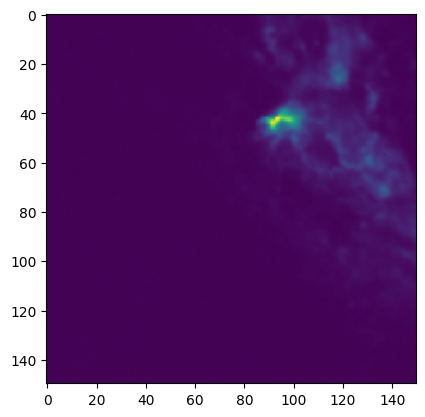

In [5]:
cube[300, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

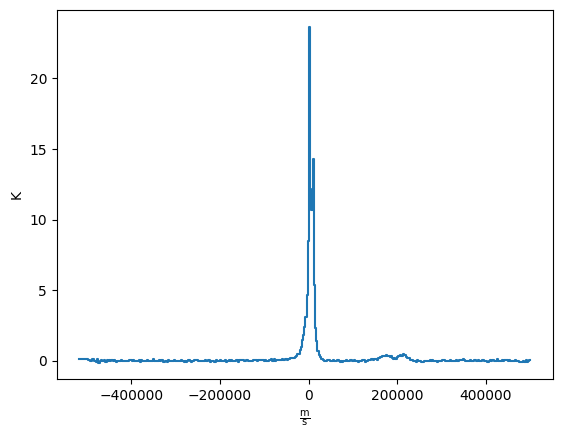

In [6]:
cube[:, 75, 75].quicklook()  # Extract a single spectrum through the data cube

In [7]:
_, lat, _ = cube.world[0, :, 0]  # extract latitude world coordinates from cube
_, _, lon = cube.world[0, 0, :]  # extract longitude world coordinates from cube

In [8]:
# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(
    xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1]
)

print(sub_cube)

SpectralCube with shape=(450, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


In [9]:
sub_cube_slab = sub_cube.spectral_slab(-300.0 * u.km / u.s, 300.0 * u.km / u.s)

print(sub_cube_slab)

SpectralCube with shape=(226, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    226  type_s: VRAD      unit_s: m / s  range:  -299683.842 m / s:  301268.441 m / s


In [10]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km / u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.km / u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
moment_0.write('hi_moment_0.fits')
moment_1.write('hi_moment_1.fits')

print("Moment_0 has units of: ", moment_0.unit)
print("Moment_1 has units of: ", moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


In [11]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN'
CUNIT : 'deg' 'deg'
CRVAL : 303.75 -40.0
CRPIX : 11.557620817843869 40.3723930634757
PC1_1 PC1_2  : 1.0 0.0
PC2_1 PC2_2  : 0.0 1.0
CDELT : -0.1494444443846667 0.1538888888273333
NAXIS : 0  0


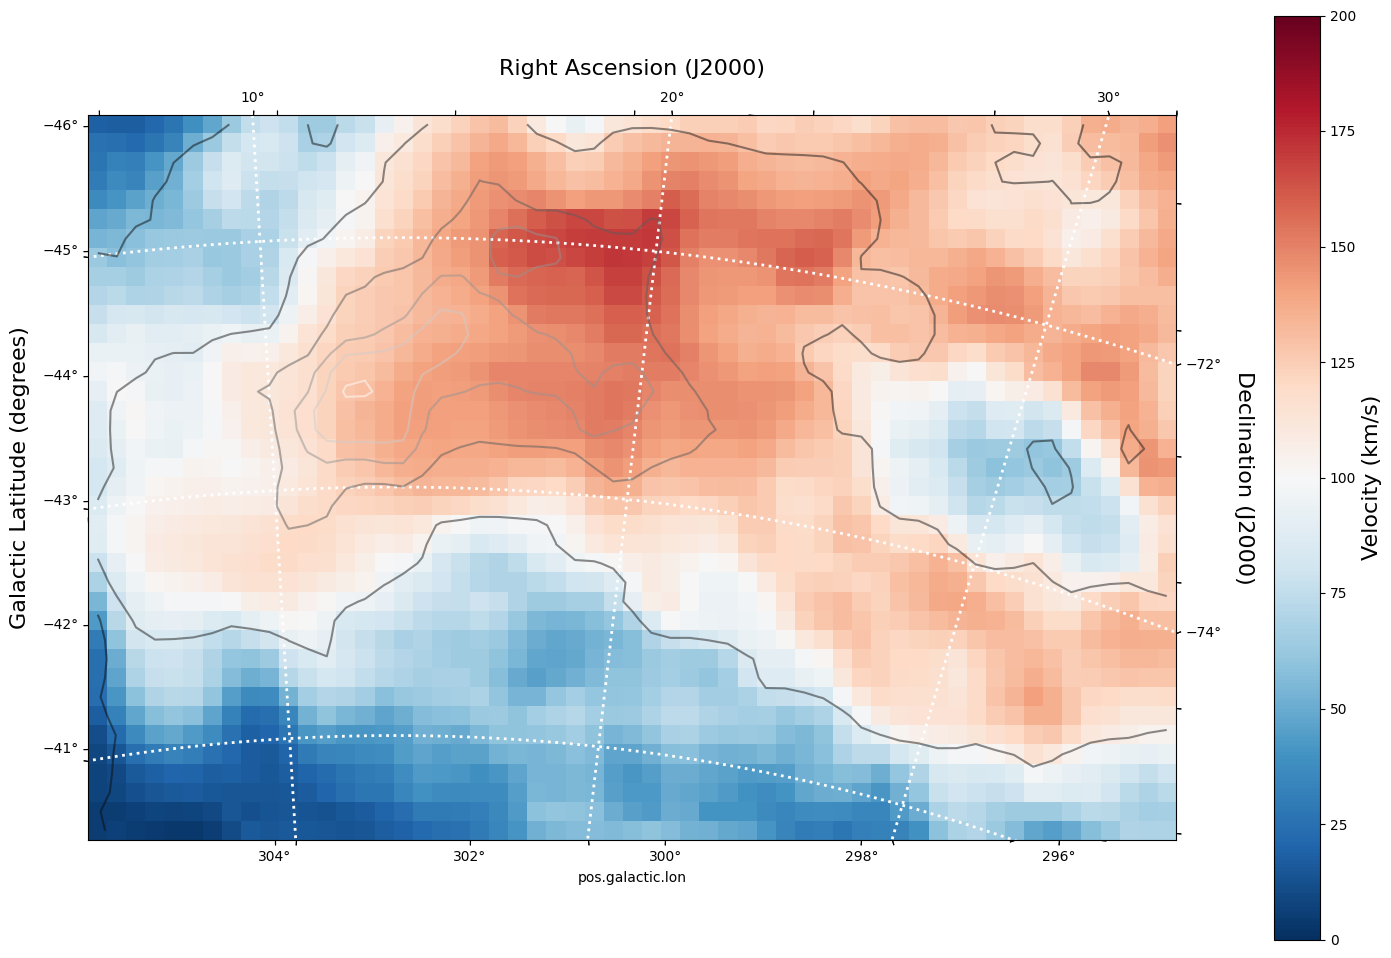

In [12]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap="RdBu_r", vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=0.07)
cbar.set_label("Velocity (km/s)", size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay("fk5")
overlay.grid(color="white", ls="dotted", lw=2)
overlay[0].set_axislabel("Right Ascension (J2000)", fontsize=16)
overlay[1].set_axislabel("Declination (J2000)", fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap="Greys_r", alpha=0.5, levels=levels)

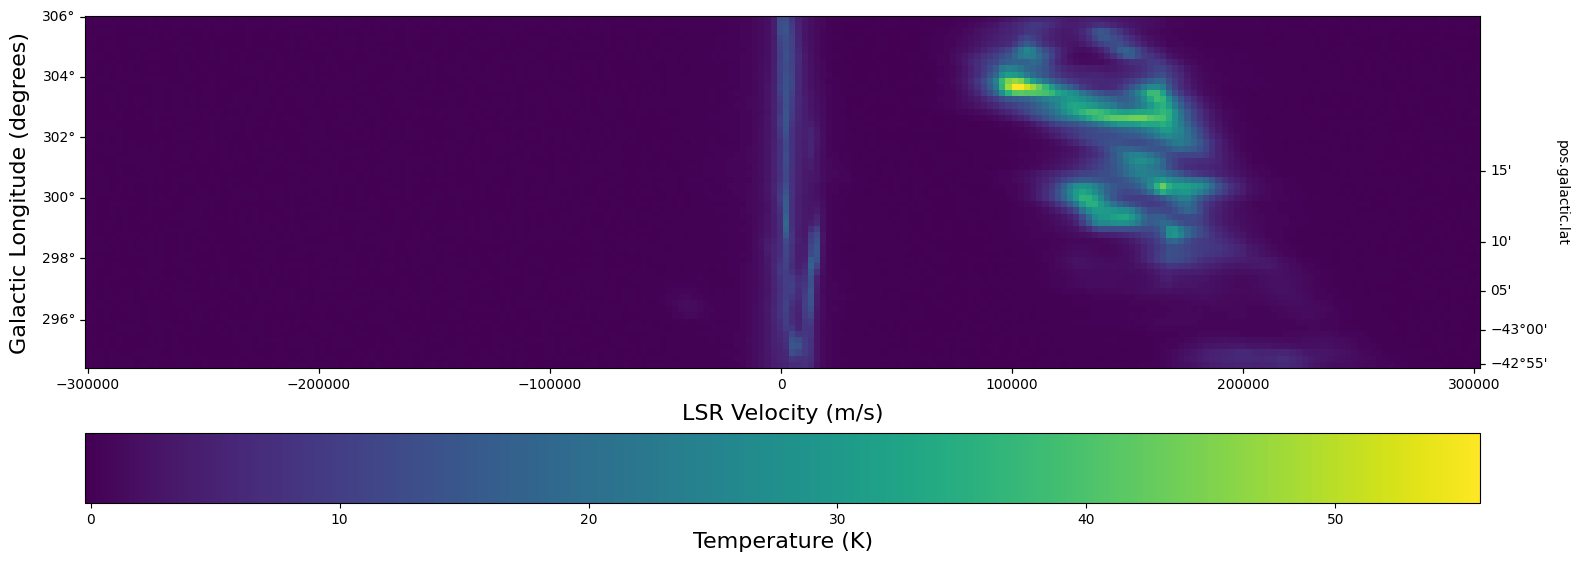

In [13]:
lat_slice = 18  # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=("y", lat_slice, "x"))

# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=0.07, orientation="horizontal")
cbar.set_label("Temperature (K)", size=16)

In [14]:
# Query for Herschel data in a 1 degree radius around the SMC
result = ESASky.query_region_maps("SMC", radius=1 * u.deg, missions="Herschel")

print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 15 column(s) and 28 row(s) 


In [15]:
result["HERSCHEL"].keys()

['fov',
 'postcard_url',
 'product_url',
 'observation_id',
 'observation_oid',
 'ra_deg',
 'dec_deg',
 'target_name',
 'instrument',
 'filter',
 'start_time',
 'end_time',
 'duration',
 'observing_mode_name',
 'stc_s']

In [16]:
result["HERSCHEL"]["filter"]

"70, 160"
"250, 350, 500"
"100, 160"
"70, 160"
"70, 160"
"70, 160"
"70, 160"
"250, 350, 500"
"100, 160"
"70, 160"
"70, 160"


In [18]:
filters = result["HERSCHEL"]["filter"].astype(str)  # Convert the list of filters from the query to a string

# Construct a boolean mask, searching for only the desired filters
mask = np.array(["250, 350, 500" == s for s in filters], dtype="bool")

# Re-construct a new TableList object containing only our desired query entry
target_obs = TableList(
    {"HERSCHEL": result["HERSCHEL"][mask]}
)  # This will be passed into ESASky.get_maps()

IR_images = ESASky.get_maps(target_obs)  # Download the images
IR_images["HERSCHEL"][0]["350"].info()  # Display some information about the 350 micron image

INFO: Starting download of HERSCHEL data. (5 files) [astroquery.esasky.core]
INFO: Maps available at D:\Deep\Projects\Learning_Astropy\Maps. [astroquery.esasky.core]
Filename: Maps\HERSCHEL\anonymous1766742720/hspirepmw401_25pxmp_0110_m7303_1342198565_1342198566_1462476888800.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     184   ()      
  1  image         1 ImageHDU        47   (2407, 2141)   float64   
  2  error         1 ImageHDU        47   (2407, 2141)   float64   
  3  coverage      1 ImageHDU        47   (2407, 2141)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   84R x 1C   [326A]   
  6  HistoryTasks    1 BinTableHDU     46   65R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   450R x 10C   [1K, 20A, 13A, 196A, 1L, 1K, 1L, 74A, 11A, 41A]   


In [19]:
herschel_header = IR_images["HERSCHEL"][0]["350"]["image"].header
herschel_wcs = WCS(IR_images["HERSCHEL"][0]["350"]["image"])  # Extract WCS information
herschel_imagehdu = IR_images["HERSCHEL"][0]["350"]["image"]  # Extract Image data
print(herschel_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN'
CUNIT : 'deg' 'deg'
CRVAL : 18.99666058287459 -71.82876374906319
CRPIX : 1063.0 1517.0
NAXIS : 2407  2141


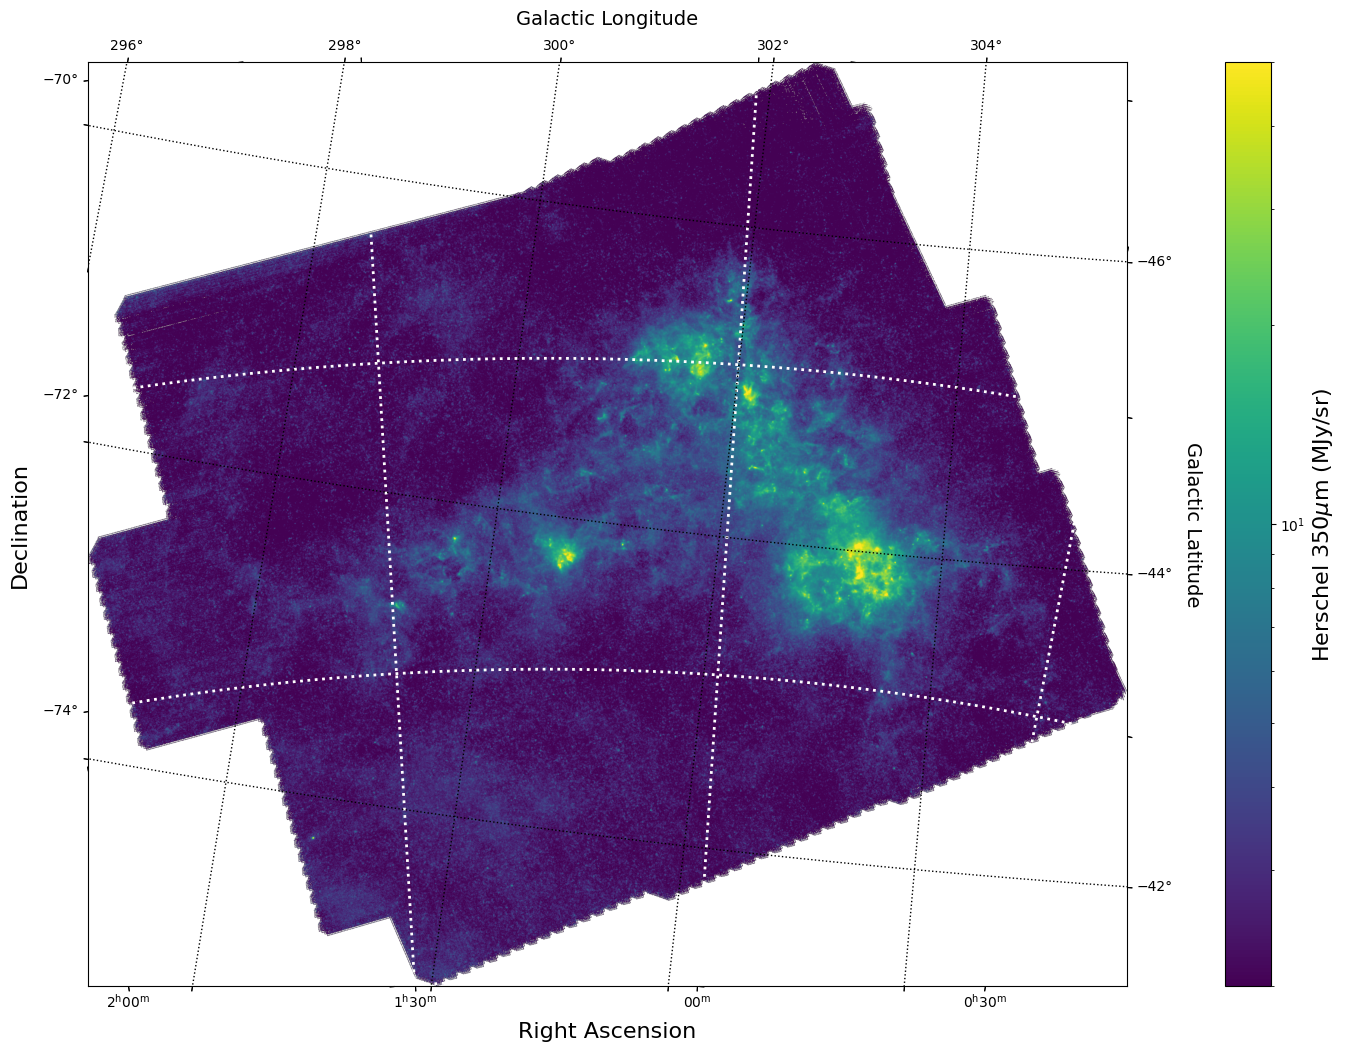

In [20]:
# Set Nans to zero
himage_nan_locs = np.isnan(herschel_imagehdu.data)
herschel_data_nonans = herschel_imagehdu.data
herschel_data_nonans[himage_nan_locs] = 0

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_data_nonans, cmap="viridis", norm=LogNorm(vmin=2, vmax=50))
# ax.invert_yaxis() # Flips the Y axis

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize=16)
ax.set_ylabel("Declination", fontsize=16)
ax.grid(color="white", ls="dotted", lw=2)

# Add a colorbar
cbar = plt.colorbar(im, pad=0.07)
cbar.set_label("".join(["Herschel 350" r"$\mu$m ", "(", herschel_header["BUNIT"], ")"]), size=16)

# Overlay set of Galactic Coordinate Axes
overlay = ax.get_coords_overlay("galactic")
overlay.grid(color="black", ls="dotted", lw=1)
overlay[0].set_axislabel("Galactic Longitude", fontsize=14)
overlay[1].set_axislabel("Galactic Latitude", fontsize=14)

(-0.5, 2140.5)

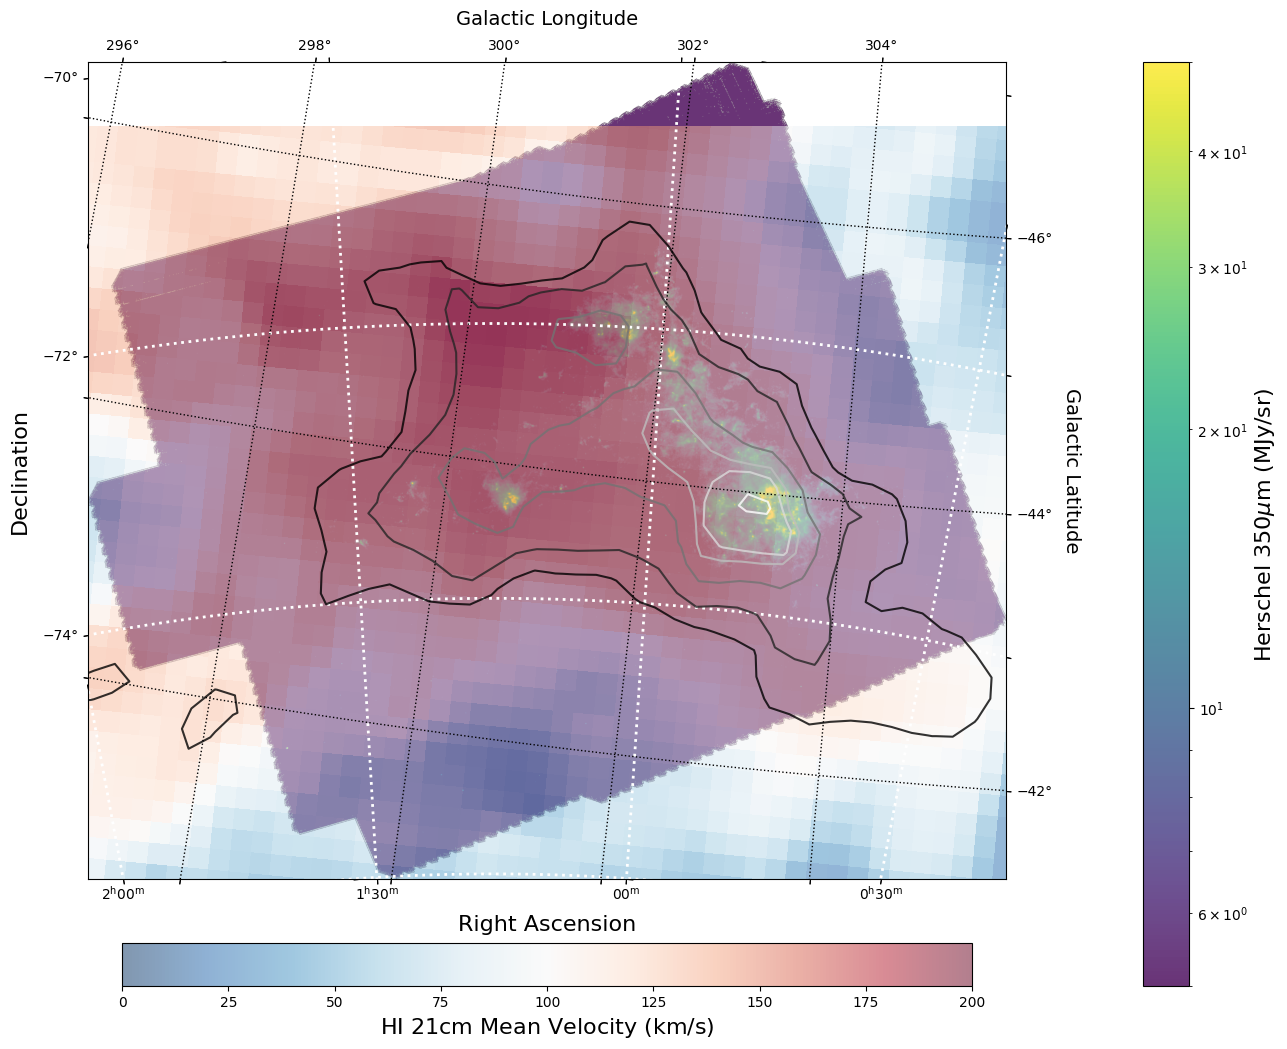

In [21]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=herschel_wcs)

# Display the moment map image
im = ax.imshow(
    herschel_data_nonans, cmap="viridis", norm=LogNorm(vmin=5, vmax=50), alpha=0.8
)
# ax.invert_yaxis() # Flips the Y axis

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize=16)
ax.set_ylabel("Declination", fontsize=16)
ax.grid(color="white", ls="dotted", lw=2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# Add a colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=-0.1)
cbar.set_label(
    "".join(["Herschel 350" r"$\mu$m ", "(", herschel_header["BUNIT"], ")"]), size=16
)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay("galactic")
overlay.grid(color="black", ls="dotted", lw=1)
overlay[0].set_axislabel("Galactic Longitude", fontsize=14)
overlay[1].set_axislabel("Galactic Latitude", fontsize=14)

hi_transform = ax.get_transform(
    hi_column_density.wcs
)  # extract axes Transform information for the HI data

# Overplot column density contours
levels = (2e21, 3e21, 5e21, 7e21, 8e21, 1e22)  # Define contour levels to use
ax.contour(
    hi_column_density.hdu.data,
    cmap="Greys_r",
    alpha=0.8,
    levels=levels,
    transform=hi_transform,
)  # include the transform information with the keyword "transform"

# Overplot velocity image so we can also see the Gas velocities
im_hi = ax.imshow(
    moment_1.hdu.data,
    cmap="RdBu_r",
    vmin=0,
    vmax=200,
    alpha=0.5,
    transform=hi_transform,
)

# Add a second colorbar for the HI Velocity information
cbar_hi = plt.colorbar(im_hi, orientation="horizontal", fraction=0.046, pad=0.07)
cbar_hi.set_label("HI " r"$21$cm Mean Velocity (km/s)", size=16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

In [22]:
print("IR Resolution (dx,dy) = ", herschel_header["cdelt1"], herschel_header["cdelt2"])

print(
    "HI Resolution (dx,dy) = ",
    hi_column_density.hdu.header["cdelt1"],
    hi_column_density.hdu.header["cdelt1"],
)

IR Resolution (dx,dy) =  -0.002777777777778 0.002777777777777778
HI Resolution (dx,dy) =  -0.14944444438467 -0.14944444438467


In [23]:
rescaled_herschel_data, _ = reproject_interp(
    herschel_imagehdu,
    # reproject the Herschal image to match the HI data
    hi_column_density.hdu.header,
)

rescaled_herschel_imagehdu = fits.PrimaryHDU(
    data=rescaled_herschel_data,
    # wrap up our reprojection as a new fits HDU object
    header=hi_column_density.hdu.header,
)

(37.5, -0.5)

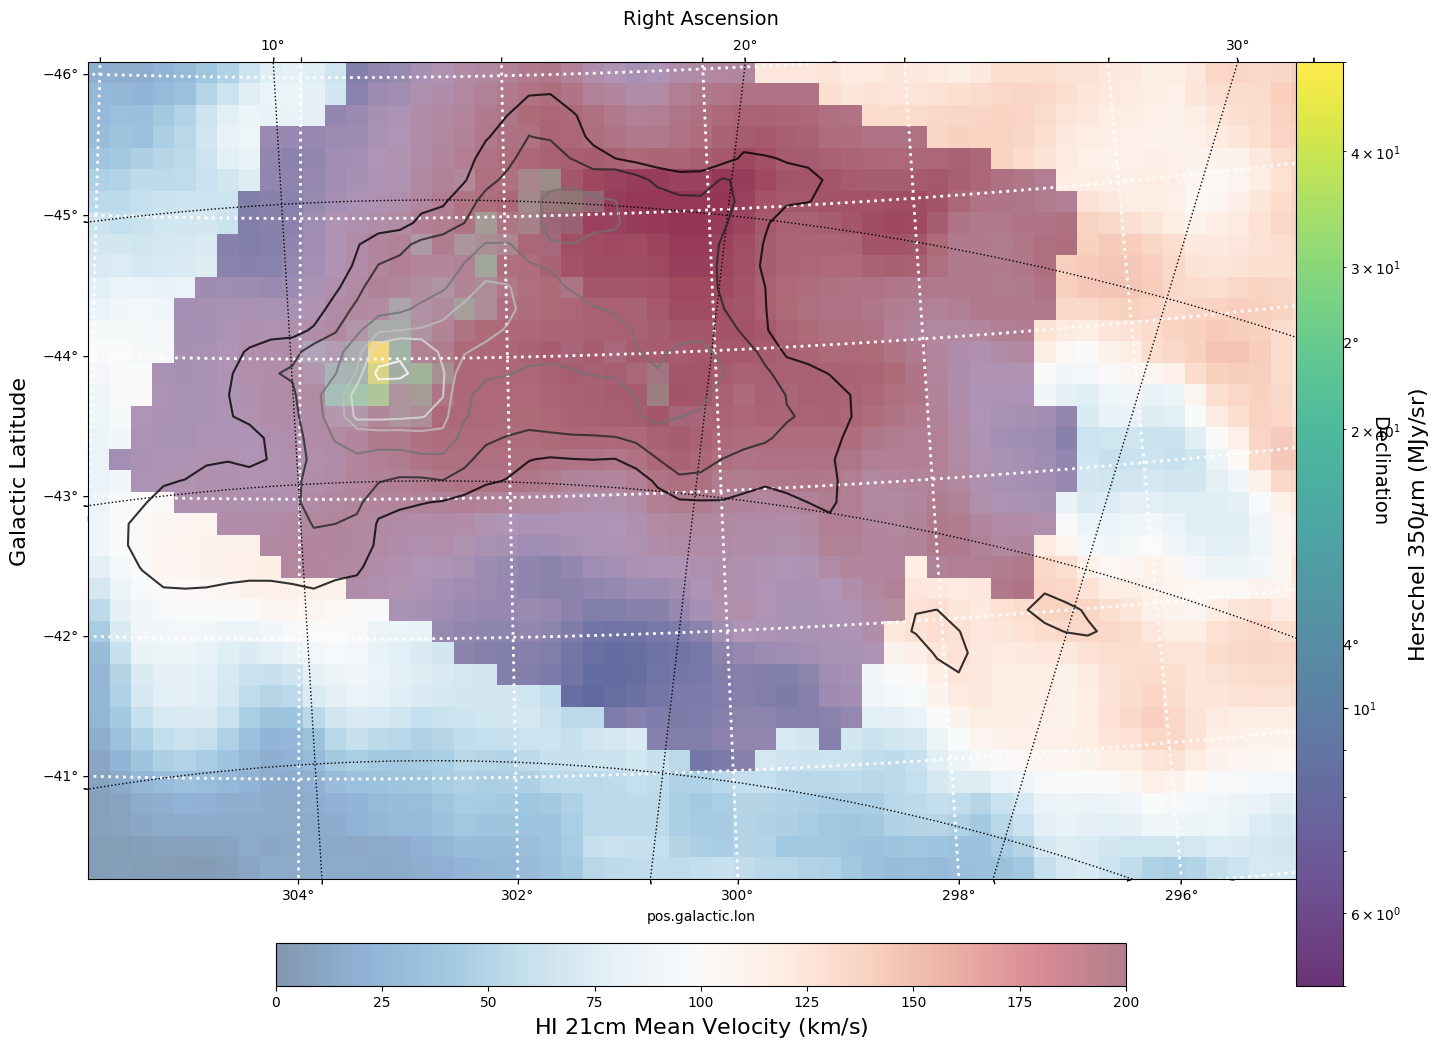

In [24]:
# Set Nans to zero
image_nan_locs = np.isnan(rescaled_herschel_imagehdu.data)
rescaled_herschel_data_nonans = rescaled_herschel_imagehdu.data
rescaled_herschel_data_nonans[image_nan_locs] = 0

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=WCS(rescaled_herschel_imagehdu))

# Display the moment map image
im = ax.imshow(
    rescaled_herschel_data_nonans,
    cmap="viridis",
    norm=LogNorm(vmin=5, vmax=50),
    alpha=0.8,
)
# im = ax.imshow(rescaled_herschel_imagehdu.data, cmap = 'viridis',
#               norm = LogNorm(), vmin = 5, vmax = 50, alpha = .8)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude", fontsize=16)
ax.set_ylabel("Galactic Latitude", fontsize=16)
ax.grid(color="white", ls="dotted", lw=2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# Add a colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=-0.1)
cbar.set_label(
    "".join(["Herschel 350" r"$\mu$m ", "(", herschel_header["BUNIT"], ")"]), size=16
)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay("fk5")
overlay.grid(color="black", ls="dotted", lw=1)
overlay[0].set_axislabel("Right Ascension", fontsize=14)
overlay[1].set_axislabel("Declination", fontsize=14)

hi_transform = ax.get_transform(
    hi_column_density.wcs
)  # extract axes Transform information for the HI data

# Overplot column density contours
levels = (2e21, 3e21, 5e21, 7e21, 8e21, 1e22)  # Define contour levels to use
ax.contour(
    hi_column_density.hdu.data,
    cmap="Greys_r",
    alpha=0.8,
    levels=levels,
    transform=hi_transform,
)  # include the transform information with the keyword "transform"

# Overplot velocity image so we can also see the Gas velocities
im_hi = ax.imshow(
    moment_1.hdu.data,
    cmap="RdBu_r",
    vmin=0,
    vmax=200,
    alpha=0.5,
    transform=hi_transform,
)

# Add a second colorbar for the HI Velocity information
cbar_hi = plt.colorbar(im_hi, orientation="horizontal", fraction=0.046, pad=0.07)
cbar_hi.set_label("HI " r"$21$cm Mean Velocity (km/s)", size=16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)